# Absorção de Raios-X - Análise de dados

Notebook com análise de dados do experimento de absorção de raios-x por diferentes filtros ($Zr$, $Mo$, $Al$)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.constants import h as planck, e, c
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

h = planck / e

In [2]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_theme()

In [3]:
lattice     = { 'NaCl': 0.564E-9, 'KBr': 0.659E-9 }
cols        = [ 'Sem_Filtro', 'Zr', 'Mo', 'Al' ]
filters     = { 'Zr': pd.read_csv('zr.csv'), 'Mo': pd.read_csv('mo.csv'), 'Al': pd.read_csv('al.csv'), 'O': pd.read_csv('o.csv'), 'C': pd.read_csv('c.csv'), 'N': pd.read_csv('n.csv')}
density     = { 'Zr': 6.49, 'Mo': 10.28, 'Al': 2.70, 'Zr02': 5.68, 'ZrC': 6.73, 'ZrN': 7.09 }
borders     = { 'NaCl': { 'Zr': 0.0, 'Mo': 0.0, 'Al': 0.0 }, 'KBr': { 'Zr': 0.0, 'Mo': 0.0, 'Al': 0.0 } }

In [4]:
coefficient = {
    'Zr': interp1d(filters['Zr']['Energia'] * 1E6, filters['Zr']['Atenuacao']),
    'Mo': interp1d(filters['Mo']['Energia'] * 1E6, filters['Mo']['Atenuacao']),
    'Al': interp1d(filters['Al']['Energia'] * 1E6, filters['Al']['Atenuacao']),
    'O': interp1d(filters['O']['Energia'] * 1E6, filters['O']['Atenuacao']),
    'C': interp1d(filters['C']['Energia'] * 1E6, filters['C']['Atenuacao']),
    'N': interp1d(filters['N']['Energia'] * 1E6, filters['N']['Atenuacao']),
}

In [5]:
attenuation = {
    'Zr': lambda e: coefficient['Zr'](e) * density['Zr'],
    'Mo': lambda e: coefficient['Mo'](e) * density['Mo'],
    'Al': lambda e: coefficient['Al'](e) * density['Al'],
    'ZrO2': lambda e: (coefficient['Zr'](e) + 2 * coefficient['O'](e)) / 3 * density['Zr02'],
    'ZrC': lambda e: (coefficient['Zr'](e) + coefficient['C'](e)) / 3 * density['ZrC'],
    'ZrN': lambda e: (coefficient['Zr'](e) + coefficient['N'](e)) / 3 * density['ZrN'],
}

In [6]:
df = { 'NaCl': [], 'KBr': [] }

## Análise de Absortância

### $NaCl$ - Cloreto de Sódio

In [7]:
df['NaCl'] = pd.read_csv('nacl.csv')

In [8]:
df['NaCl']['sBeta']         = df['NaCl']['Beta'] * 0 + np.radians(0.05)

df['NaCl']['Wavelength']    = lattice['NaCl'] * np.sin(np.radians(df['NaCl']['Beta']))
df['NaCl']['sWavelength']   = np.sqrt( lattice['NaCl']**2 * np.cos(np.radians(df['NaCl']['Beta']))**2 * df['NaCl']['sBeta']**2 )

df['NaCl']['Energia']       = h * c / df['NaCl']['Wavelength']
df['NaCl']['sEnergia']      = np.sqrt(( h * c * df['NaCl']['sWavelength'] / df['NaCl']['Wavelength']**2 )**2)

In [9]:
for col in cols: df['NaCl'][f's{col}'] = np.sqrt(df['NaCl'][col]) / 10

[]

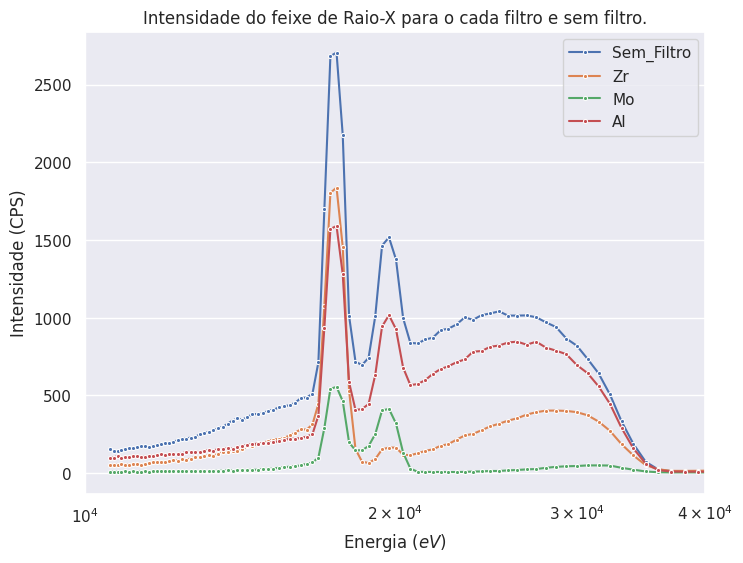

In [10]:
plt.title('Intensidade do feixe de Raio-X para o cada filtro e sem filtro.')
for col in cols: sns.lineplot(data=df['NaCl'], x='Energia', y=col, label=col, marker='.')
plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(10000, 40000)
plt.legend()
plt.xscale('log')
plt.savefig('nacl_absorption.png', dpi=300, bbox_inches='tight')
plt.plot()

In [11]:
df['NaCl']['Absortancia_Zr'] = df['NaCl']['Sem_Filtro'] / df['NaCl']['Zr']
df['NaCl']['Absortancia_Mo'] = df['NaCl']['Sem_Filtro'] / df['NaCl']['Mo']
df['NaCl']['Absortancia_Al'] = df['NaCl']['Sem_Filtro'] / df['NaCl']['Al']

In [12]:
df['NaCl']['sAbsortancia_Zr'] = np.sqrt( (df['NaCl']['sSem_Filtro']/df['NaCl']['Zr'])**2 + ( df['NaCl']['Sem_Filtro'] * df['NaCl']['sZr'] / df['NaCl']['Zr']**2 )**2 )
df['NaCl']['sAbsortancia_Mo'] = np.sqrt( (df['NaCl']['sSem_Filtro']/df['NaCl']['Mo'])**2 + ( df['NaCl']['Sem_Filtro'] * df['NaCl']['sMo'] / df['NaCl']['Mo']**2 )**2 )
df['NaCl']['sAbsortancia_Al'] = np.sqrt( (df['NaCl']['sSem_Filtro']/df['NaCl']['Al'])**2 + ( df['NaCl']['Sem_Filtro'] * df['NaCl']['sAl'] / df['NaCl']['Al']**2 )**2 )

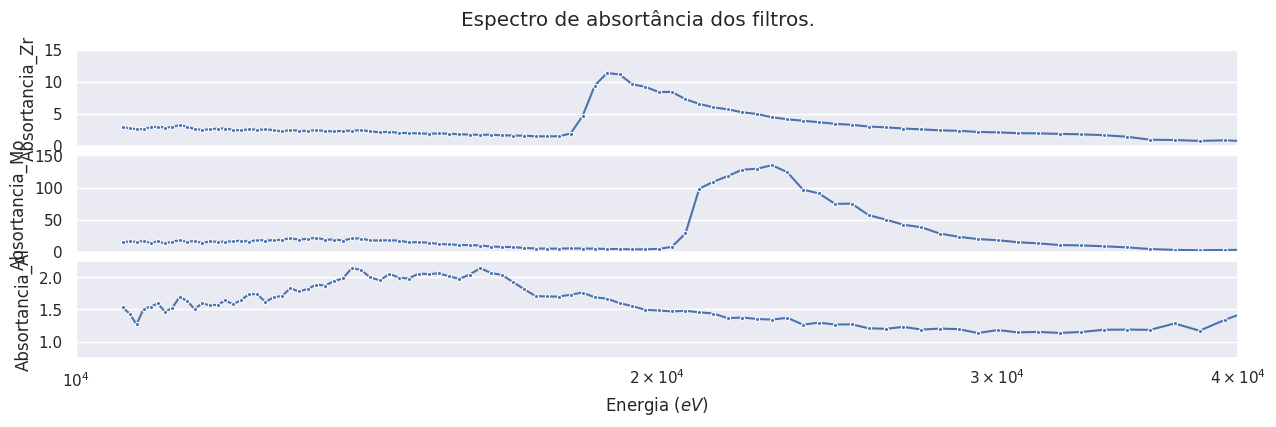

In [13]:
figs, axs = plt.subplots(3, sharex=True, figsize=(15,4), gridspec_kw={ 'hspace': 0.1 })
plt.suptitle('Espectro de absortância dos filtros.')

ylims = ((0, 15), (0, 150), (0.75, 2.25))
for i,col in enumerate(cols[1:]):
  sns.lineplot(data=df['NaCl'], x='Energia', y=f'Absortancia_{col}', marker='.', ax=axs[i])
  axs[i].set_ylim(ylims[i])

plt.xlabel('Energia ($eV$)')
plt.xlim(10000, 40000)
plt.xscale('log')

plt.savefig('nacl_abs_filtes.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
def exponential(x, H, A, a, b): return H + A * np.exp(a * x + b)

In [15]:
p0s   = (
  (0, 70, -1.1E-4, 0),
  (0, 100000, -2.9E-4, 0),
  (0, 2.3, -2.5E-5, 0)
)
ranges = ([ 15, 38 ], [ 15, 31 ], [ 15, 41 ])
fits  = [ [], [], [] ]

In [16]:
for i in range(3):
  fits[i] = curve_fit(
      exponential,
      xdata=df['NaCl']['Energia'][ranges[i][0]:ranges[i][1]],
      ydata=df['NaCl'][f'Absortancia_{cols[i+1]}'][ranges[i][0]:ranges[i][1]],
      p0=p0s[i]
  )

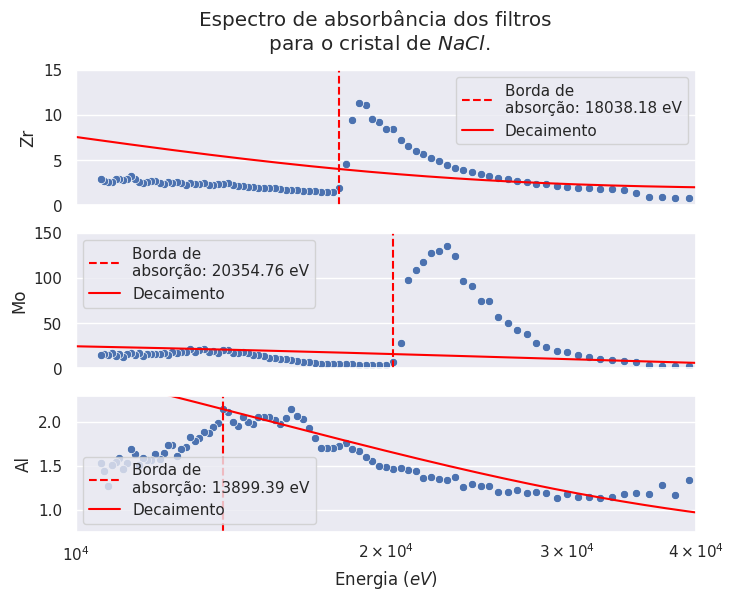

In [79]:
figs, axs = plt.subplots(3, sharex=True, gridspec_kw={ 'hspace': 0.2 })
plt.suptitle('Espectro de absorbância dos filtros\n para o cristal de $NaCl$.')

x = np.linspace(10000, 40000, 1000)

ylims = ((0, 15), (0, 150), (0.75, 2.3))
borders_ = ( (10, 3), (100, 7), (2.145, 0) )
for i,col in enumerate(cols[1:]):
  borders['NaCl'][col] = float(df['NaCl']['Energia'][find_peaks(df['NaCl'][f'Absortancia_{col}'], height=borders_[i][0])[0] + borders_[i][1]])
  axs[i].vlines(x=borders['NaCl'][col], ymin=0, ymax=200, color='red', linestyle='--', label=f'Borda de\nabsorção: {borders["NaCl"][col]:.2f} eV')

  sns.scatterplot(data=df['NaCl'], x='Energia', y=f'Absortancia_{col}', marker='o', ax=axs[i])
  sns.lineplot(x=x, y=exponential(x, fits[i][0][0], fits[i][0][1], fits[i][0][2], fits[i][0][3]), color='red', label='Decaimento', ax=axs[i])
  axs[i].set_ylim(ylims[i])

plt.xlabel('Energia ($eV$)')
plt.xlim(10000, 40000)
plt.xscale('log')

axs[0].set_ylabel('Zr')
axs[1].set_ylabel('Mo')
axs[2].set_ylabel('Al')

plt.savefig('nacl_abs_filters.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
for i in range(3):
  print(fits[i][0])

[ 1.89591026e+00  2.02880291e+02 -3.27138289e-04  3.15147159e+00]
[ 3.03211167e+00  1.10589488e+05 -3.12944451e-04  4.46933097e-01]
[ 1.07493403e+00  2.79082706e+00 -1.65361089e-04  1.42502822e+00]


### $KBr$ - Brometo de Potássio

In [19]:
df['KBr'] = pd.read_csv('kbr.csv')

In [49]:
df['KBr']['sBeta']         = df['KBr']['Beta'] * 0 + np.radians(0.05)

df['KBr']['Wavelength']    = lattice['KBr'] * np.sin(np.radians(df['KBr']['Beta']))
df['KBr']['sWavelength']   = np.sqrt( lattice['KBr']**2 * np.cos(np.radians(df['KBr']['Beta']))**2 * df['KBr']['sBeta']**2 )

df['KBr']['Energia']       = h * c / df['KBr']['Wavelength']
df['KBr']['sEnergia']      = np.sqrt(( h * c * df['KBr']['sWavelength'] / df['KBr']['Wavelength']**2 )**2)

In [50]:
for col in cols: df['KBr'][f's{col}'] = np.sqrt(df['KBr'][col]) / 10

[]

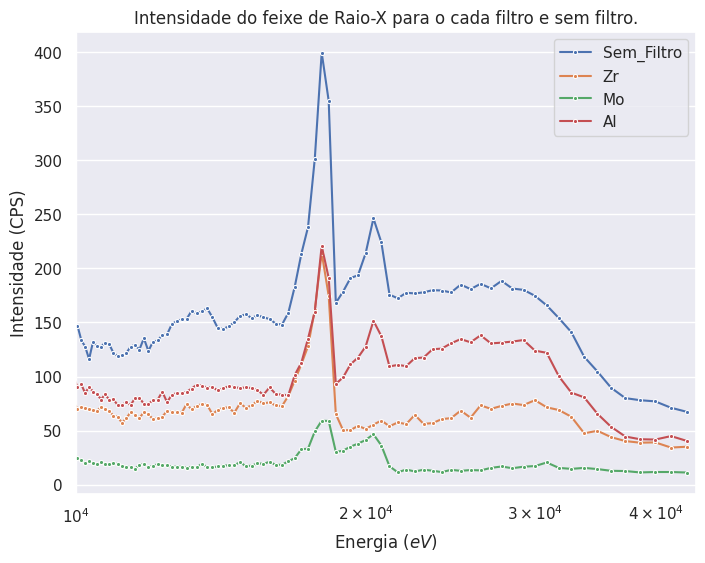

In [21]:
plt.title('Intensidade do feixe de Raio-X para o cada filtro e sem filtro.')
for col in cols: sns.lineplot(data=df['KBr'], x='Energia', y=col, label=col, marker='.')
plt.xlabel('Energia ($eV$)')
plt.ylabel('Intensidade (CPS)')
plt.xlim(10000, 44000)
plt.legend()
plt.xscale('log')
plt.savefig('kbr_absorption.png', dpi=300, bbox_inches='tight')
plt.plot()

In [22]:
df['KBr']['Absortancia_Zr'] = df['KBr']['Sem_Filtro'] / df['KBr']['Zr']
df['KBr']['Absortancia_Mo'] = df['KBr']['Sem_Filtro'] / df['KBr']['Mo']
df['KBr']['Absortancia_Al'] = df['KBr']['Sem_Filtro'] / df['KBr']['Al']

In [51]:
df['KBr']['sAbsortancia_Zr'] = np.sqrt( (df['KBr']['sSem_Filtro']/df['KBr']['Zr'])**2 + ( df['KBr']['Sem_Filtro'] * df['KBr']['sZr'] / df['KBr']['Zr']**2 )**2 )
df['KBr']['sAbsortancia_Mo'] = np.sqrt( (df['KBr']['sSem_Filtro']/df['KBr']['Mo'])**2 + ( df['KBr']['Sem_Filtro'] * df['KBr']['sMo'] / df['KBr']['Mo']**2 )**2 )
df['KBr']['sAbsortancia_Al'] = np.sqrt( (df['KBr']['sSem_Filtro']/df['KBr']['Al'])**2 + ( df['KBr']['Sem_Filtro'] * df['KBr']['sAl'] / df['KBr']['Al']**2 )**2 )

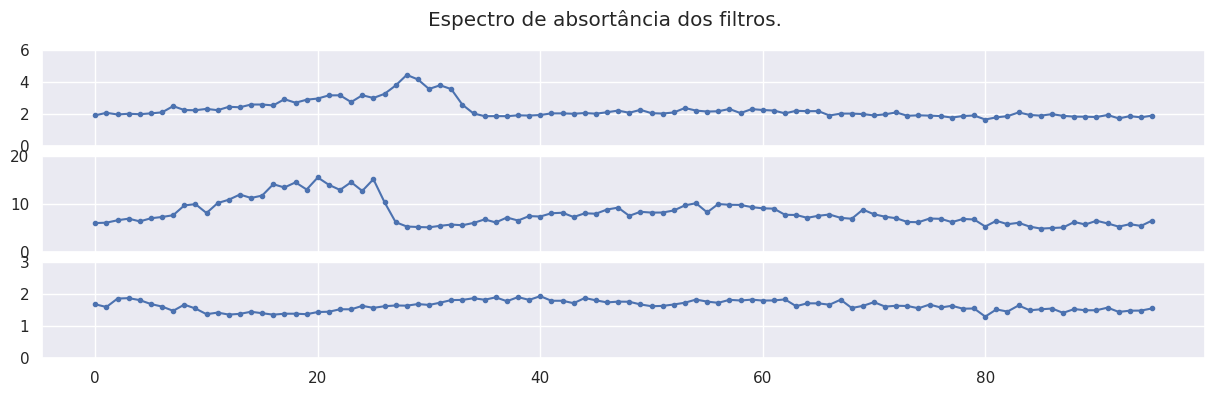

In [23]:
figs, axs = plt.subplots(3, sharex=True, figsize=(15,4), gridspec_kw={ 'hspace': 0.1 })
plt.suptitle('Espectro de absortância dos filtros.')

ylims = ((0, 6), (0, 20), (0, 3))
for i,col in enumerate(cols[1:]):
  axs[i].plot(df['KBr'][f'Absortancia_{col}'], marker='.')
  axs[i].set_ylim(ylims[i])

plt.show()

In [24]:
p0s   = (
  (0, 70, -1.1E-4, 0),
  (0, 100000, -2.9E-4, 0),
  (0, 2.3, -2.5E-5, 0)
)
ranges = ([ 0, 28 ], [ 0, 25 ], [ 15, 41 ])
fits  = [ [], [], [] ]

In [25]:
for i in range(3):
  fits[i] = curve_fit(
      exponential,
      xdata=df['KBr']['Energia'][ranges[i][0]:ranges[i][1]],
      ydata=df['KBr'][f'Absortancia_{cols[i+1]}'][ranges[i][0]:ranges[i][1]],
      p0=p0s[i]
  )

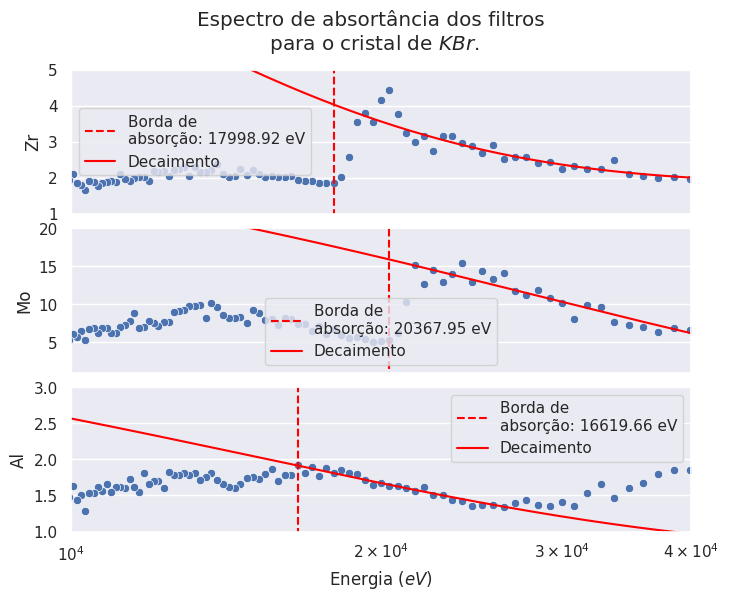

In [95]:
figs, axs = plt.subplots(3, sharex=True, gridspec_kw={ 'hspace': 0.1 })
plt.suptitle('Espectro de absortância dos filtros\n para o cristal de $KBr$.')

x = np.linspace(10000, 40000, 1000)

ylims = ((1, 5), (1, 20), (1, 3))
borders_ = ((4, 7), (15.2, 8), (1.9, 0))
for i,col in enumerate(cols[1:]):
  borders['KBr'][col] = float(df['KBr']['Energia'][find_peaks(df['KBr'][f'Absortancia_{col}'], height=borders_[i][0])[0] + borders_[i][1]])
  axs[i].vlines(x=borders['KBr'][col], ymin=0, ymax=200, color='red', linestyle='--', label=f'Borda de\nabsorção: {borders["KBr"][col]:.2f} eV')

  sns.scatterplot(data=df['KBr'], x='Energia', y=f'Absortancia_{col}', ax=axs[i])
  sns.lineplot(x=x, y=exponential(x, fits[i][0][0], fits[i][0][1], fits[i][0][2], fits[i][0][3]), color='red', label='Decaimento', ax=axs[i])
  axs[i].set_ylim(ylims[i])

axs[0].set_ylabel('Zr')
axs[1].set_ylabel('Mo')
axs[2].set_ylabel('Al')

plt.xlabel('Energia ($eV$)')
plt.xlim(10000, 40000)
plt.xscale('log')

plt.savefig('kbr_abs_filters.png', dpi=300, bbox_inches='tight')
plt.show()

## Estimativa da espessura do filtro

In [96]:
thickness = { 'NaCl': { 'Zr': [], 'Mo': [] }, 'KBr': { 'Zr': [], 'Mo': [] } }

In [97]:
for crys in ('NaCl', 'KBr'):
  for filt in ('Zr', 'Mo'):
    i = df[crys]['Energia'].index[df[crys]['Energia'] == borders[crys][filt]].tolist()[0]

    m = np.log( df[crys][f'Absortancia_{filt}'][i] ) / attenuation[filt]( borders[crys][filt] )
    s = df[crys][f'sAbsortancia_{filt}'][i] / (df[crys][f'Absortancia_{filt}'][i] * attenuation[filt]( borders[crys][filt] ))

    thickness[crys][filt] = m * 1E-2, s * 1E-2

In [100]:
thickness

{'NaCl': {'Zr': (1.0526225016146589e-05, 8.760507475721245e-08),
  'Mo': (2.4971057221031094e-05, 1.1435536705603417e-07)},
 'KBr': {'Zr': (1.012036131412519e-05, 1.3774783903296633e-07),
  'Mo': (2.0597833693244048e-05, 1.976855414997705e-07)}}

In [103]:
thickness['NaCl']['Zr'][0] * 1E6

10.526225016146588

In [104]:
thickness['NaCl']['Mo'][0] * 1E6

24.971057221031096

In [98]:
(thickness['NaCl']['Zr'][0] - thickness['KBr']['Zr'][0]) / np.sqrt(thickness['NaCl']['Zr'][1]**2 + thickness['KBr']['Zr'][1]**2)

2.48621571064403

In [99]:
(thickness['NaCl']['Mo'][0] - thickness['KBr']['Mo'][0]) / np.sqrt(thickness['NaCl']['Mo'][1]**2 + thickness['KBr']['Mo'][1]**2)

19.149018831884263